In [1]:
##### Code catalog
##### 12/09/2023 - Organize from One-node-final folder. Github has another final version, compare and update later
#####
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.stats import beta
from itertools import combinations, count
import scipy
import time
import random
import copy
import scipy.io
import collections
import sys
import os
%matplotlib inline
#%run pure_strategy_selection.ipynb  #include simple selection algorithm

from utils import *
from game import Game

## Configurations

In [2]:
# Pick polarization function
calculate_polarization = calculate_polarization1

network_name = 'reddit'
# network_name = 'karate'

np.set_printoptions(precision=3)

# Game Parameters
game_rounds = 1
memory = 0  # for zero-sum, the memory is always 0
experiment = 1

# Create the 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)

## Creating Network
### 1. Import Network

In [3]:
network = import_network(network_name)

G, s, n = network.init()
network_anl = network.network_anl
nxG = nx.from_numpy_array(G)

### 2. Network Visualization

<Figure size 2000x2000 with 0 Axes>

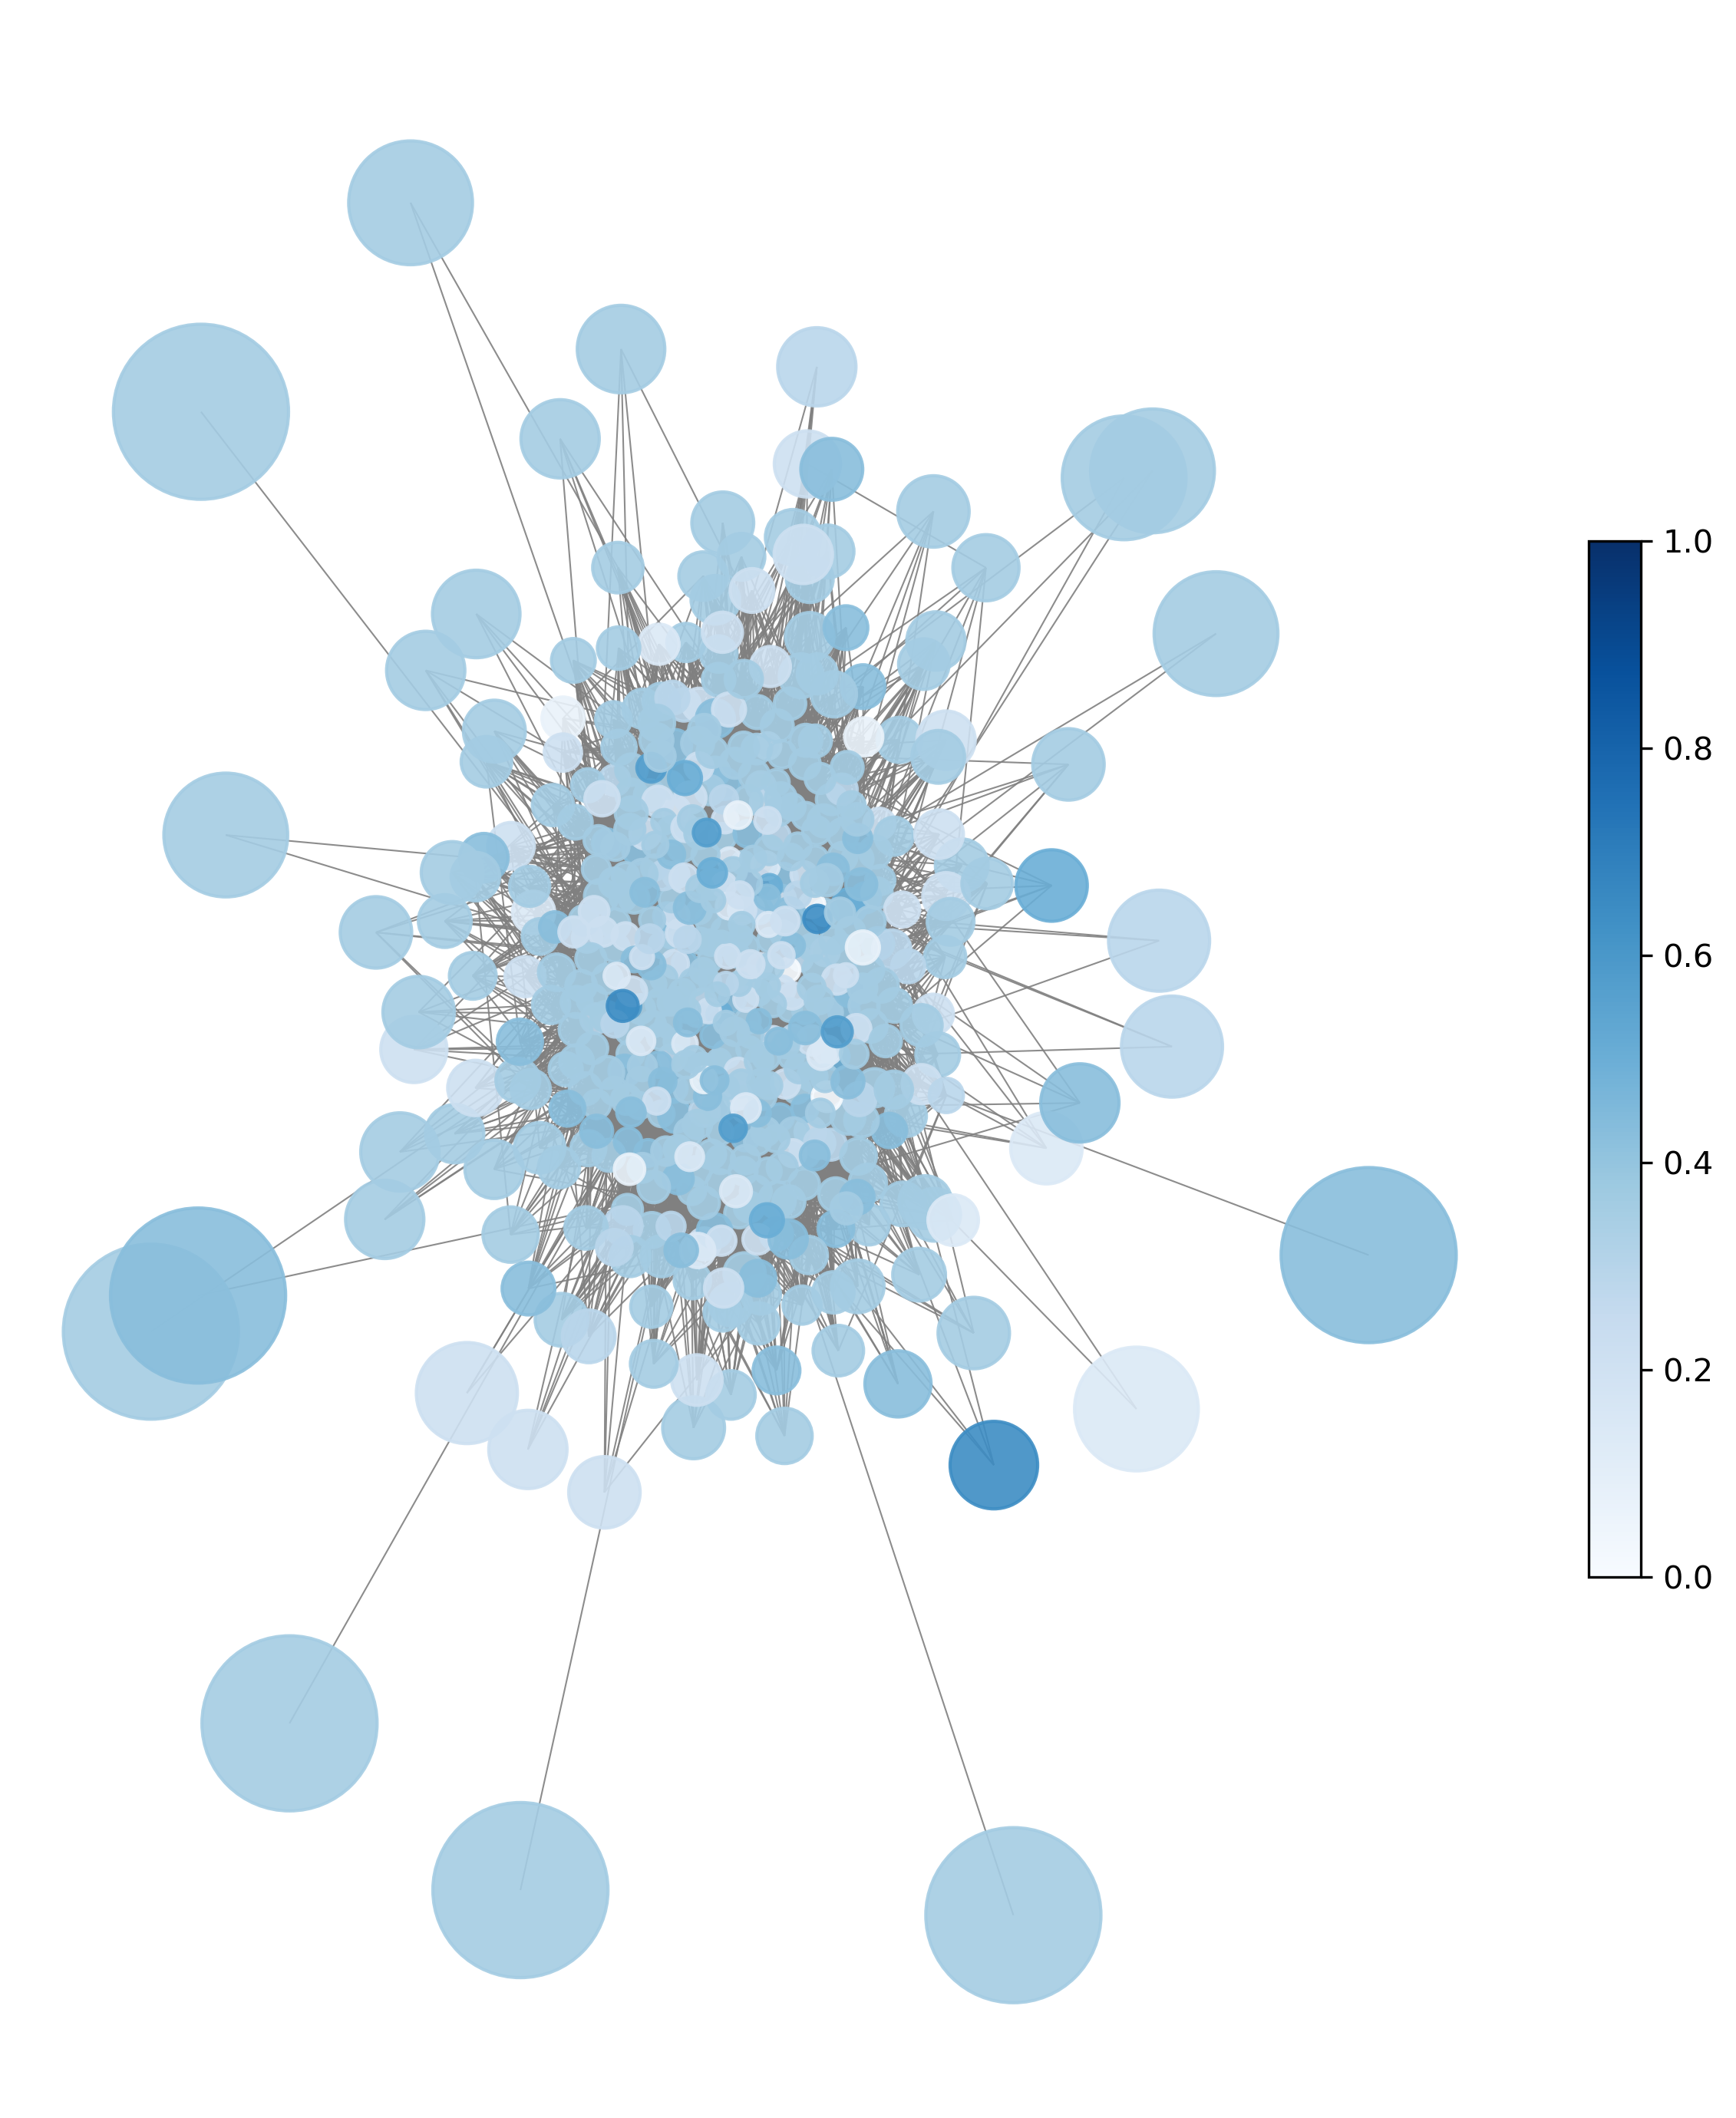

In [4]:
############################ Make Innate Opinion ################################

# Calculate Key Values & Visualization #######################################3
# the Laplacian matrix
L = scipy.sparse.csgraph.laplacian(G, normed=False)
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)  Adjacency Matrix
# call the function to calculate the number of edges
m = num_edges(L, n)
columnsum_ij = np.sum(A, axis=0)
plt.figure(figsize=(20, 20))


node_edges = get_node_edges(G, n)
min_equi = []
max_equi = []

# create color map
color_map = []
for node in nxG:
    if node in min_equi:
        color_map.append('orange')
    elif node in max_equi:
        color_map.append('Red')
    else:
        # color_map.append('#1f77b4')
        color_map.append('grey')

# create node color map value
# convert opinion array into data frame
s_use = s.flatten().tolist()
new_s = [i * 30 for i in s_use]
# create a data frame with index at column 1, opinion at column 2
df = pd.DataFrame(new_s, columns=['Opinion'])

# create node sizes
node_sizes = []
for i in node_edges:
    node_size = 1/i*3000
    node_sizes.append(node_size)

# visualize the network in high resolution
plt.figure(figsize=(8, 9), dpi=300)  # Set the DPI for high resolution
# draw subgraph for highlights
# set a seed so the network will not give random layout
my_pos = nx.spring_layout(nxG, k=0.3, seed=2)
nx.draw(nxG, pos=my_pos, with_labels=False, node_color=df['Opinion'].astype(int),
        cmap=plt.cm.Blues, node_size=node_sizes, edge_color='grey', width=0.5,
        font_color='black', font_size=12, font_weight='bold', alpha=0.9)
# nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')

sm = plt.cm.ScalarMappable(
    cmap=plt.cm.Blues,
    norm=plt.Normalize(vmin=0, vmax=1)
)

# visualize the network in high resolution
cbar = plt.colorbar(sm, shrink=0.5, ax=plt.gca())

### 3. Network Property Visualization

Text(0, 0.5, 'Number of Agents')

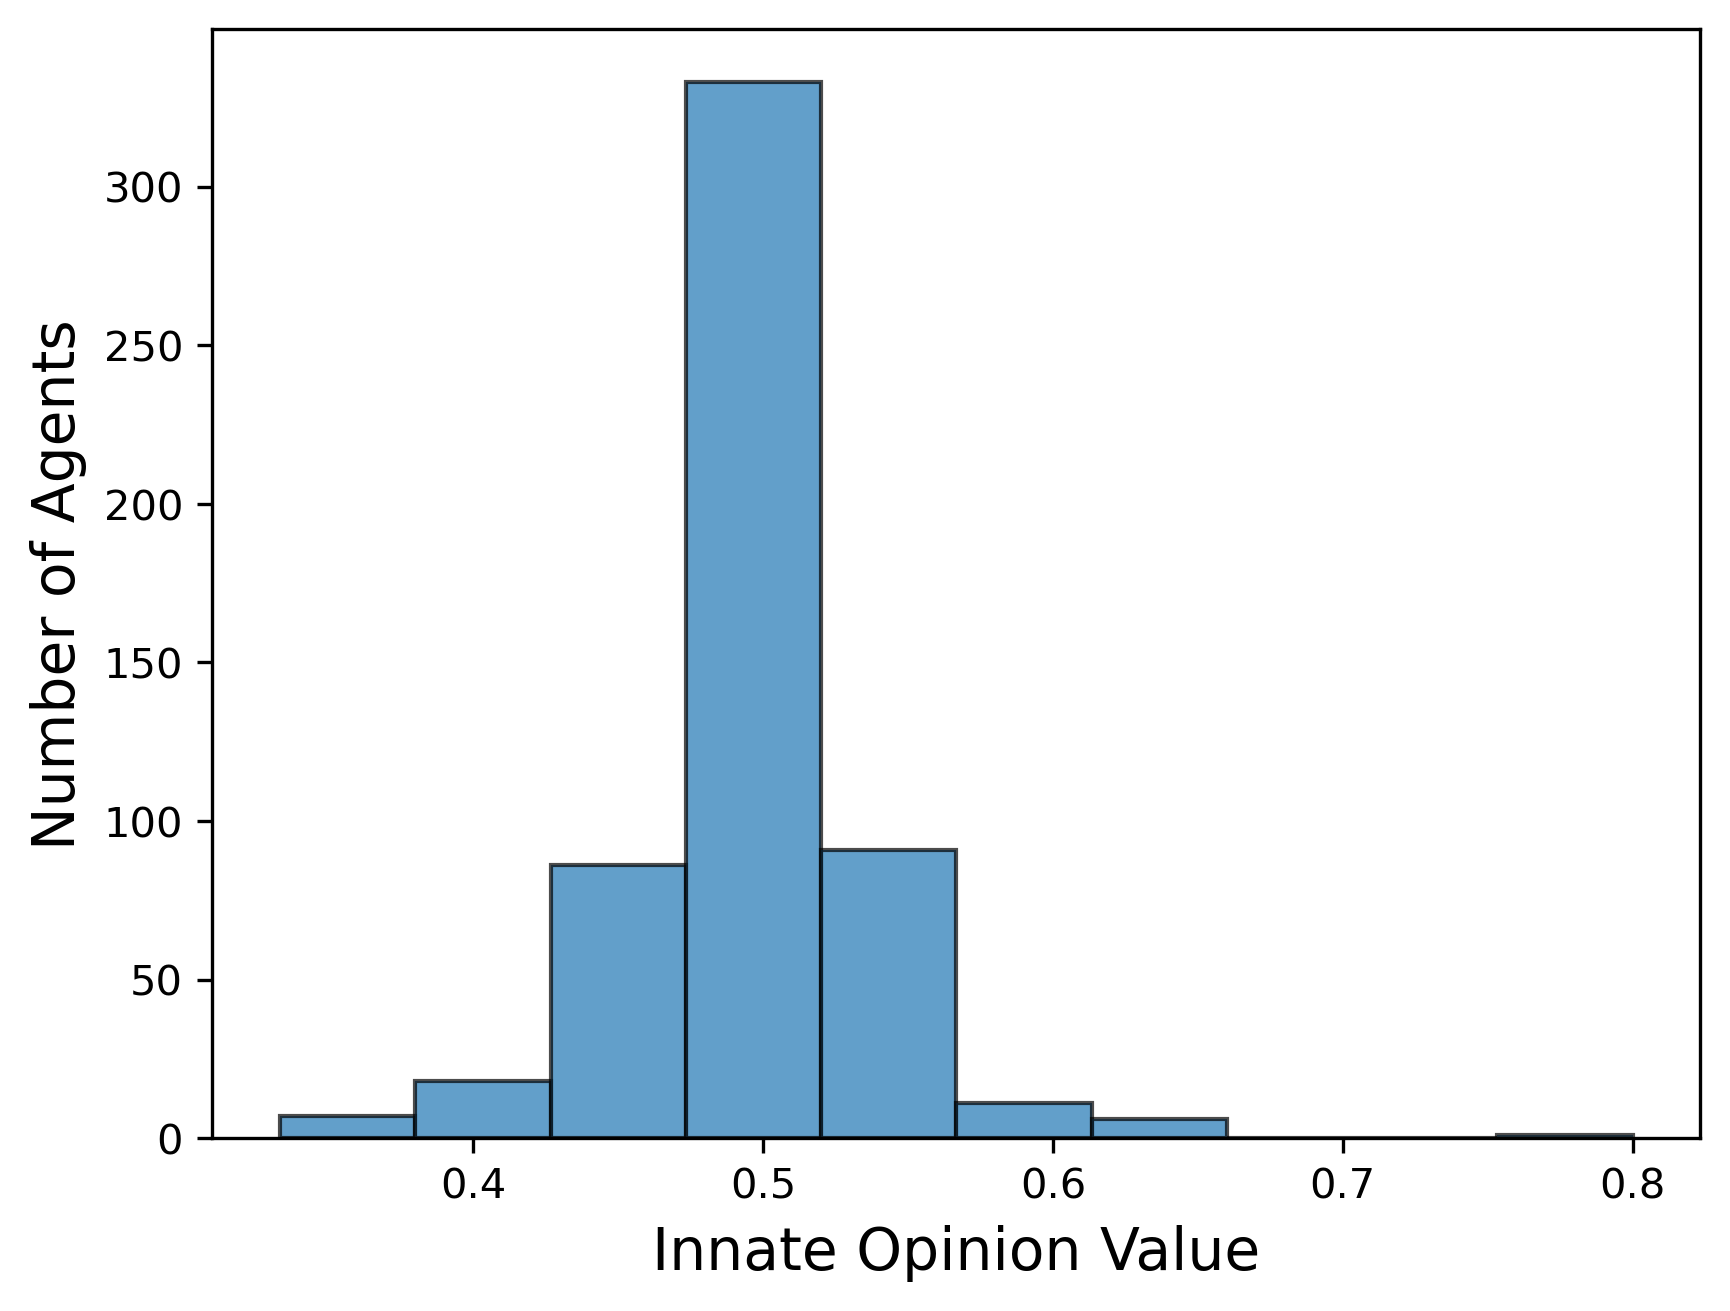

In [5]:
plt.figure(dpi=300)
# Create a histogram
plt.hist(s, bins=10, edgecolor='black', alpha=0.7)
# new_list = range(0, 3)
# plt.ylim(0,8)
# plt.yticks(range(0, 10, 2))
# Add labels and title
plt.xlabel('Innate Opinion Value', fontsize=14)
plt.ylabel('Number of Agents', fontsize=14)
# Save the figure as a high-quality PNG image
# plt.savefig(f'results/${network_type}_opinion_histograms.png', dpi=800)  # Adjust dpi for higher quality

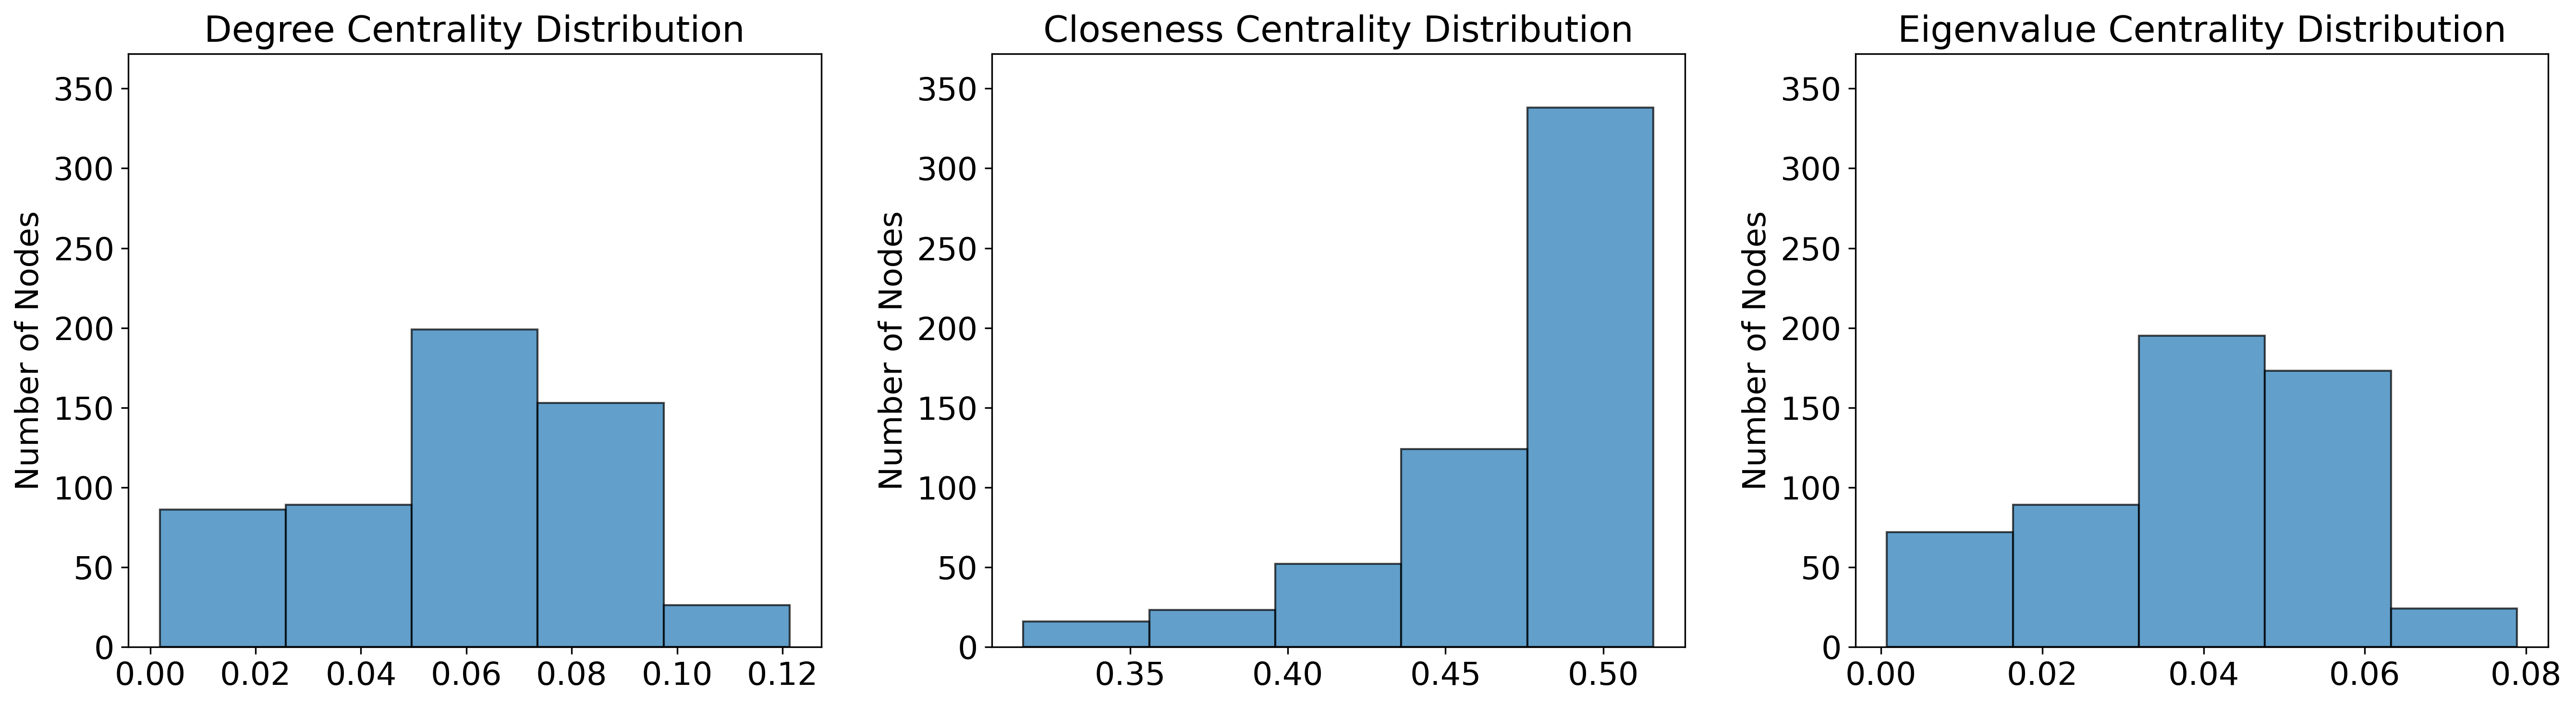

In [6]:
degree_df = calculate_centrality_and_convert_to_df(nxG, nx.degree_centrality)
closeness_df = calculate_centrality_and_convert_to_df(nxG, nx.closeness_centrality)
eigenvector_df = calculate_centrality_and_convert_to_df(nxG, nx.eigenvector_centrality)

bins = 5
# value of the bar with the highest count
max_bar_value = max(
    pd.cut(degree_df[0], bins=5).value_counts().max(),
    pd.cut(closeness_df[0], bins=5).value_counts().max(),
    pd.cut(eigenvector_df[0], bins=5).value_counts().max(),
)
# top padding is added so that the bar doesn't touch the top of the plot
ylim = max_bar_value + max_bar_value / 10

# Plot histograms of centrality measures in a horizontal layout
# Set DPI to 300 for higher resolution
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

plot_centrality_histogram(axs[0], degree_df, 'Degree Centrality Distribution', bins, ylim)
plot_centrality_histogram(axs[1], closeness_df, 'Closeness Centrality Distribution', bins, ylim)
plot_centrality_histogram(axs[2], eigenvector_df, 'Eigenvalue Centrality Distribution', bins, ylim)

plt.tight_layout()
# Save the figure as a high-quality PNG image
# Adjust dpi for higher quality
plt.savefig(f'results/{network_name}_centrality_histograms.png', dpi=800)

plt.show()

In [7]:
# Analyze node feature
nod_ind = 29  # index of node - start with 0

network_anl(s, n, G, nod_ind)
print(f"Minimum Eigen_value Centrality: {np.min(eigenvector_df)}")
print(f"Maximum opinion: {min(s)}")

29 opinion: [0.5]
29 neighbors: (array([ 11, 107, 125, 150, 189, 211, 284, 311, 319, 325, 350, 379, 406,
       412, 485, 486]),)
Opinion rank of this agent is: [155]
_______________Degree Centrality___________________
rank of this agent is : [90]
0.028985507246376812
                           
_______________Closeness Rank________________________
rank of this agent is : [90]
0.43567482241515393
                           
_______________Page Rank_____________________________
rank of this agent is : [93]
0.02108802985242771
                           
Agent's opinion gap to mean opinion is ranked as: [155]
Minimum Eigen_value Centrality: 0.0007349912233008693
Maximum opinion: [0.333]


### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [8]:
# Calculate network polarization
calculate_polarization(s, n, A, L)

Innate_polarization:	0.9625703647920463
Equi_polarization:	0.005278437803904967
Difference:		-0.9572919269881413


### 5. Innate Op and Game

# Fictitious Play Start !


### Prepare for the game

In [9]:
game = Game()
gameResult = game.run(game_rounds, memory, s, n, A, L)

    Agent67's opinion 0.5 changed to 0.5959526620086422
Network reaches equilibrium Polarization: 0.005332527285309471
fre_max at spot: 1.0
    Agent434's opinion 0.4 changed to 0.5783006532583539
Network reaches equilibrium Polarization: 0.005264711971398147
v1 67
v2 434
min_history: [(434, 0.5783006532583539)]
Counter({(434, 0.5783006532583539): 1})
fla_min_fre at the spot
{(434, 0.5783006532583539): 1}
1
_____________________
Game 1
_____________________
                                
Maximizer finds its target agent:
    Agent481's opinion 0.5 changed to 1
pop
                                
Minimizer finds its target agent:
    Agent481's opinion 0.5 changed to 0.5
pop
Not Reached Nash Equilibrium at Equi_Min = 0.006221406632436699 and Equi_Max = 0.06978130479566186
min_recent_0_touched: [481]
max_recent_0_touched: [481]
Min last 100 action: [481]


In [10]:
# experiment = 10

# experiment_note = str('Note: This experiment has initial condition. Game round:'+str(Game_rounds)+'.')
# (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100) = all_fre_limited_touch(s, n)


In [11]:
# # MAXimizer's distribution of LAST 100 iteration
# print('Max_distribution_last_100')
# max_l100_fre = max_history_last_100/500
# print(max_l100_fre [np.nonzero(max_l100_fre)])
# print(np.nonzero(max_l100_fre))

max_fre = gameResult.max_history/game_rounds
print(max_fre[np.nonzero(max_fre)])
print('Max_distribution_all')
print([np.nonzero(max_fre)])
# print for small network
# # Print for Large Network
# print(np.nonzero(max_l100_fre))

print("__________________________________________")

# # MINimizer's Strategy in the last 100 round
# print('Min_distribution_last_100')
# counter_h=collections.Counter(min_touched_last_100)  #return a dictionary include {'min_option': count of this choice}
# print(counter_h.keys())
# counter=collections.Counter(min_touched_last_100)
# fla_min_fre = np.array(list(counter.values()))/(500) #return only frequency of all min options in order
# print('fla_min_fre')
# print(fla_min_fre)
# print(min_touched_last_100)

# return a dictionary include {'min_option': count of this choice}
counter_1h = collections.Counter(gameResult.min_history)
# print(counter_1h.keys())
# return a dictionary include {'min_option': count of this choice}
counter_1 = collections.Counter(gameResult.min_touched_all)

# return only frequency of all min options in order
fla_min_fre_1 = np.array(list(counter_1.values()))/game_rounds
print('Min_distribution_all')
print(fla_min_fre_1)
print(counter_1)

# print(counter_1h)

[1. 1.]
Max_distribution_all
[(array([ 67, 481]), array([0, 1]))]
__________________________________________
Min_distribution_all
[1.]
Counter({481: 1})


In [12]:
# agent = 18
# network_anl(s,n,G,18)
# network_anl(s,n,G,19)

## Save the Network and Game Result to the file

In [13]:
# Save the files
pd.DataFrame(gameResult.payoff_matrix).to_csv(f'results/Karate Payoff Matrix{experiment}.csv')
pd.DataFrame(gameResult.min_touched_all).to_csv(f'results/Karate Min Overall{game_rounds}.csv')
pd.DataFrame(gameResult.min_history).to_csv(f'results/Karate Min agent & op Overall{game_rounds}.csv')
pd.DataFrame(gameResult.max_history).to_csv(f'results/Karate Max Overall {game_rounds}.csv')

# Save the original standard output
original_stdout = sys.stdout

with open(f'results/Result{network_name.capitalize()}.{experiment}Pure.txt', "w") as f:
    sys.stdout = f  # Change the standard output to the file we created.

    # print(experiment_note)
    print('Initial Condition -(agent, opinion, pol)')
    print(f'Innate op {s}')
    print(f'Adjacency matrix {G}')
    print(f'Max:\t{gameResult.first_max}')
    print(f'Min:\t{gameResult.first_min}')

    print("In the Last 100 Rounds")
    print('_____________________')

    # MAX distribution of LAST 100 iteration
    print('Max_distribution')
    max_l100_fre = gameResult.max_history_last_100/100
    print(max_l100_fre[np.nonzero(max_l100_fre)])
    # print for small network
    # print(max_history_last_100)
    # # Print for Large Network
    print(np.nonzero(max_l100_fre))

    # MIN Strategy in the last 100 round
    # return a dictionary include {'min_option': count of this choice}
    counter = collections.Counter(gameResult.min_touched_last_100)
    # print(counter)
    # return only frequency of all min options in order
    fla_min_fre = np.array(list(counter.values()))/100
    # print('Min_frequency')
    # print(list(counter.keys()))
    print('Min_distribution_last_100')
    print(fla_min_fre)
    # return a dictionary include {'min_option': count of this choice}
    counter_h = collections.Counter(gameResult.min_history_last_100)
    print(counter_h)

    # then stop at Game 202
    print(f'min_recent_{memory}_touched:\t{gameResult.min_touched}')
    print(f'max_recent_{memory}_touched:\t{gameResult.max_touched}')

    print(f'In Overall {game_rounds} Rounds')
    print('_____________________')

    max_fre = gameResult.max_history/game_rounds
    # print('Max_frequency')
    # print(max_history)
    print('Max_distribution')
    print(max_fre[np.nonzero(max_fre)])
    print(np.nonzero(max_fre))

    # Min Strategy in the Overall
    # return a dictionary include {'min_option': count of this choice}
    counter_1 = collections.Counter(gameResult.min_touched_all)
    # return only frequency of all min options in order
    fla_min_fre_all = np.array(list(counter_1.values())) / game_rounds
    print('Min_dist_all')
    print(fla_min_fre_all)
    print('Min_distribution')
    # return a dictionary include {'min_option': count of this choice}
    counter_a = collections.Counter(gameResult.min_history)
    print(counter_a)
    # print(payoff_matrix)

# Reset the standard output to its original value
sys.stdout = original_stdout

In [14]:
counter = collections.Counter(gameResult.min_history)
print(f'counter:\t{counter}')
fla_min_fre = np.array(list(counter.values()))/game_rounds
print(f'fla_min_fre:\t{fla_min_fre}')

counter:	Counter({(434, 0.5783006532583539): 1, (481, 0.5): 1})
fla_min_fre:	[1. 1.]
